# LLM-as-a-judge

## Variable Definitions

In [1]:
import pandas as pd
import os
from tqdm import tqdm
tqdm.pandas()

from src.generate import load_llama, simple_call_llama
from src.data import files_to_df, read_document


N_EXPECTED_SAMPLES = 35

model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--prometheus-eval--prometheus-7b-v2.0/snapshots/66ffb1fc20beebfb60a3964a957d9011723116c5"
source_path = "output/samples/en/phase_2/"
prompts_path = "utils/prompts"

path_gen = os.path.join(source_path, "generated")
path_orig = os.path.join(source_path, "original")
path_human = os.path.join(source_path, "human_eval.csv")
path_auto = os.path.join(source_path, "auto_eval.csv")

path_guidelines = os.path.join(prompts_path, "guidelines.txt")
guidelines = open(path_guidelines, "r").read()

assert os.path.exists(path_gen), f"Path {path_gen} does not exist"
assert os.path.exists(path_orig), f"Path {path_orig} does not exist"
assert os.path.exists(path_human), f"Path {path_human} does not exist"
assert os.path.exists(path_auto), f"Path {path_auto} does not exist"
assert os.path.exists(path_guidelines), f"Path {path_guidelines} does not exist"

## Load Data

### Clinical cases and Discharge summaries

35 Different pairs of clinical cases and discharge summaries are provided.

In the moment of writing this notebook, only 5 + 10 pairs have been annotated manually by one of our team members. The rest of the pairs are still pending to be annotated.

In [2]:
## Load and preprocess generated samples
df_pairs_gen = files_to_df(path_gen)
df_pairs_gen["filenameid"] = df_pairs_gen["filenameid"].str.replace("_transformed_step1", "")

## Load and preprocess original samples
df_pairs_orig = files_to_df(path_orig)

df_pairs = df_pairs_orig.merge(df_pairs_gen, on="filenameid", suffixes=("_orig", "_gen"))

assert len(df_pairs) == N_EXPECTED_SAMPLES, f"Expected {N_EXPECTED_SAMPLES} samples, got {len(df_pairs)}"

df_pairs = df_pairs.rename(columns={"text_orig": "clinical_case", "text_gen": "discharge_summary"})
df_pairs.head()

,filenameid,clinical_case,discharge_summary
0,32153696,An 80-year-old man who worked as a constructio...,**Discharge Summary**\n\n**Patient Information...
1,32470561,A 46-years-old female was admitted to our depa...,**Discharge Summary**\n\n**Patient Information...
2,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...
3,38422307,A 43-year-old female patient with uterine diff...,**Discharge Summary**\n\n**Patient Information...
4,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...


In [3]:
print(df_pairs.shape)

(35, 3)


### Human Evaluation

In [4]:
df_human = pd.read_csv(path_human)

d_score_cols = {
                        "Overall validation [Content Relevance]": "Content Relevance",
                        "Overall validation [Information Completeness]": "Information Completeness",
                        "Overall validation [Clarity and Structure]": "Clarity and Structure",
                        "Overall validation [Content Accuracy]": "Content Accuracy",
                        "Overall validation [Hallucinations]": "Hallucinations",
                        "Overall validation [Impact of Hallucinations]": "Impact of Hallucinations",
                        "Overall validation [Relevance to Practice]": "Relevance to Practice",
                        "Overall validation [Overall Quality]": "Overall Quality",
                        "Positive highlights: Describe what aspects of the synthetic discharge summaries resemble the best real EHRs? (Empty if nothing remarkable)": "Positive highlights",
                        "Negative highlights: Which aspects of the synthetic discharge summaries do not resemble well real EHRs? (Empty if nothing remarkable)": "Negative highlights",
                        "Other Comments: Do you have any other feedback or comment on the generated synthetic discharge summaries or in the original cases? (Empty if nothing remarkable)": "Other Comments"
}

df_human.rename(columns=d_score_cols, inplace=True)
df_human.rename(columns={"Original file name (e.g. 36951253)": "filenameid"}, inplace=True)

columns_to_exclude = [
    "Email Address", "Timestamp"
]
df_human = df_human.drop(columns=columns_to_exclude)
df_human = df_human.fillna("")

df_human_prompt = df_human[["filenameid"]].copy()
df_human_prompt["human_score"] = ""
df_human_prompt.loc[:, "human_score"] = df_human.iloc[:, 1:].apply(lambda x: x.to_dict(), axis=1)

df_human_prompt.head()

,filenameid,human_score
0,33857916,"{'Content Relevance': 1, 'Information Complete..."
1,34530632,"{'Content Relevance': 5, 'Information Complete..."
2,32997782,"{'Content Relevance': 4, 'Information Complete..."
3,31378248,"{'Content Relevance': 5, 'Information Complete..."
4,30785587,"{'Content Relevance': 1, 'Information Complete..."


The amount of cases annotated by the human evaluators is 15 and they contain the following information:

- `filenameid`: The name of the file
- `human_score`: A dictionary with scores associated to
  - **Content Relevance**: Does the summary focus on clinically relevant information
  - **Information Completeness**: Does the summary include all key details (diagnoses, treatments, follow-ups)?
  - **Clarity and Structure**: Is the information presented in a clear and logically structured manner like a real discharge report?
  - **Content Accuracy**: Does the report accurately reflect the clinical information provided in the input?
  - **Hallucinations**: Are there any factual inaccuracies or fabricated content in the summary?
  - **Impact of Hallucinations**: How severe are these hallucination (e.g. 1-2: Irrelevant content, 3: include details about the patients not in original, 4-5: medication doses, procedures, etc)
  - **Relevance to Practice**: Would this summary be usable in clinical practice without significant revision?
  - **Overall Quality**: How would you rate the overall quality of the discharge summary?
  
  - Free text features to be commented in error analysis. Not mandatory but open to express as much or as few as wanted.
        - **Positive/Negative highlights of generation process**
        - **Other comments on Generated/Original data sources**

In [5]:
df_human_prompt["human_score"][0]

{'Content Relevance': 1,
 'Information Completeness': 1,
 'Clarity and Structure': 4,
 'Content Accuracy': 2,
 'Hallucinations': 1,
 'Impact of Hallucinations': 1,
 'Relevance to Practice': 1,
 'Overall Quality': 2,
 'Positive highlights': 'Good structure. ',
 'Negative highlights': 'Lack of information related with clinical course and outcome. Patient evoluciton is not completly well explained. These parts are important in this case.',
 'Other Comments': ''}

In [6]:
print(df_human_prompt.shape)

(15, 2)


### Automatic Evaluation

Apart from human evaluation, we have also performed automatic evaluation about medical concepts coverage by applying named entity recognition (NER) and Entity Linking to UMLS to the clinical cases and discharge summaries.

The automatic evaluation is based on the following metrics:
- **precision**: The number of entities in the generated text that are correctly identified by the model divided by the total number of entities in the generated text.
- **recall**: The number of entities in the generated text that are correctly identified by the model divided by the total number of entities in the reference text.
- **f1**: The harmonic mean of precision and recall.

This automatic evaluation was performed over all the cases (1000 in total) and the results are stored in the `output/samples/en/phase_2/auto_eval.csv` file.

In [7]:
df_auto = pd.read_csv(path_auto).drop(columns=["cluster"])
df_auto.rename(columns={"filename": "filenameid"}, inplace=True)

df_auto_prompt = df_auto[["filenameid"]].copy()
df_auto_prompt["auto_score"] = ""
df_auto_prompt.loc[:, "auto_score"] = df_auto.iloc[:, 1:].apply(lambda x: x.to_dict(), axis=1)

df_auto_prompt.head()

,filenameid,auto_score
0,32153696,"{'precision': 0.8181817438016598, 'recall': 0...."
1,32111713,"{'precision': 0.8235293875432533, 'recall': 0...."
2,31912911_1,"{'precision': 0.4999999642857168, 'recall': 0...."
3,34962277,"{'precision': 0.9999999285714336, 'recall': 0...."
4,34118375,"{'precision': 0.9499999525000024, 'recall': 0...."


In [8]:
print(df_auto_prompt.shape)

(35, 2)


### Combination

This dataset contains all the information about the clinical cases, discharge summaries, human evaluation and automatic evaluation.

**Caution**: As the filename id is one of the fields they have to introduce, it is possible that it's wrong. We hace to check it or modify the form making them select the file from a list.

In [9]:
# model = load_llama(model_id)
df_human_prompt["filenameid"] = df_human["filenameid"].astype(str)
df_auto_prompt["filenameid"] = df_auto["filenameid"].astype(str)
df_pairs["filenameid"] = df_pairs["filenameid"].astype(str)

df_prompt = df_pairs.merge(df_human_prompt, on="filenameid").merge(df_auto_prompt, on="filenameid", how="inner")
df_prompt.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0...."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0...."
2,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666222222252, 'recall': 0...."
3,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0...."
4,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0...."


In [10]:
df_prompt.shape

(15, 5)

# Load Model

In [ ]:
from prometheus_eval.prompts import ABSOLUTE_PROMPT, SCORE_RUBRIC_TEMPLATE
from transformers import pipeline
import torch
model_id = "/gpfs/projects/bsc14/abecerr1/hub/models--meta-llama--Llama-3.2-3B-Instruct/snapshots/0cb88a4f764b7a12671c53f0838cd831a0843b95"
pipe = pipeline(
    "text-generation",
    model=model_id,
    torch_dtype=torch.bfloat16,
    # device="cuda",
    device_map="auto",
)

terminators = [
    pipe.tokenizer.eos_token_id,
    pipe.tokenizer.convert_tokens_to_ids("<|eot_id|>")
]


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


# Evaluate All Rubrics

## 1. Raw Evaluation

In [ ]:
# Likert scale evaluation rubric (ratings 1 to 5)

def generate_eval(pipe, rubric_data, instruction, response, reference_answer, template):

    rubric = SCORE_RUBRIC_TEMPLATE.format(**rubric_data)

    prompt = template.format(
        instruction=instruction,
        response=response,
        rubric=rubric,
        reference_answer=reference_answer,
    )

    # print(prompt)

    messages = [
        {
            "role": "system",
            "content": instruction
        },
        {
            "role": "user",
            "content": prompt
        }
    ]

    outputs = pipe(
                    messages,
                    max_new_tokens=256,
                    temperature=0.01,
                    # do_sample=True,
                    repetition_penalty=1.2,
                    eos_token_id=terminators,
                    pad_token_id=pipe.tokenizer.eos_token_id,
                )

    
    return outputs[0]["generated_text"][-1]["content"]


rubric_data = {
    "Content Relevance": {
        "criteria": "Does the summary focus on clinically relevant information?",
        "score1_description": "The summary largely misses the clinically relevant details.",
        "score2_description": "The summary includes only a few clinically relevant details.",
        "score3_description": "The summary covers some relevant information but omits key aspects.",
        "score4_description": "The summary covers most clinically relevant details with minor omissions.",
        "score5_description": "The summary is entirely focused on clinically relevant information."
    },
    "Information Completeness": {
        "criteria": "Does the summary include all key details (diagnoses, treatments, follow-ups)?",
        "score1_description": "Key details are largely missing from the summary.",
        "score2_description": "Only a few key details are present, with many important ones absent.",
        "score3_description": "Some key details are included, but several are missing.",
        "score4_description": "Most key details are present, though a few minor elements may be missing.",
        "score5_description": "The summary comprehensively includes all required key details."
    },
    "Clarity and Structure": {
        "criteria": "Is the information presented in a clear and logically structured manner like a real discharge report?",
        "score1_description": "The summary is poorly organized and very hard to follow.",
        "score2_description": "The structure is inconsistent and makes the content challenging to understand.",
        "score3_description": "The summary is moderately clear and structured, though improvements are needed.",
        "score4_description": "The summary is clear and well-organized with only minor issues.",
        "score5_description": "The summary is very clear, logically structured, and mimics a professional discharge report."
    },
    "Content Accuracy": {
        "criteria": "Does the report accurately reflect the clinical information provided in the input?",
        "score1_description": "The summary contains numerous inaccuracies compared to the input.",
        "score2_description": "The summary has several inaccuracies that affect its reliability.",
        "score3_description": "The summary is generally accurate but includes some errors.",
        "score4_description": "The summary is mostly accurate with only minor discrepancies.",
        "score5_description": "The summary accurately reflects the clinical information provided."
    },
    "Hallucinations": {
        "criteria": "Are there any factual inaccuracies or fabricated content in the summary?",
        "score1_description": "The summary is completely free of hallucinations or fabricated content.",
        "score2_description": "The summary is nearly free of hallucinations, with minimal issues.",
        "score3_description": "There are minor inaccuracies or fabricated details present.",
        "score4_description": "The summary shows noticeable inaccuracies or hallucinations.",
        "score5_description": "The summary contains significant fabricated or inaccurate content"
    },
    "Impact of Hallucinations": {
        "criteria": "How severe are the hallucinations?",
        "score1_description": "Hallucinations, if present, are minor and do not affect key details.",
        "score2_description": "Hallucinations are noticeable but do not significantly impact clinical relevance.",
        "score3_description": "Hallucinations include some extra details not present in the original.",
        "score4_description": "Hallucinations affect important clinical details moderately.",
        "score5_description": "Hallucinations are severe, impacting critical clinical information such as medication doses or procedures."
    },
    "Relevance to Practice": {
        "criteria": "Would this summary be usable in clinical practice without significant revision?",
        "score1_description": "The summary is not usable in its current form for clinical practice.",
        "score2_description": "The summary requires major revisions to be usable.",
        "score3_description": "The summary is moderately usable but needs some revisions.",
        "score4_description": "The summary is largely usable with only minor revisions needed.",
        "score5_description": "The summary is fully usable in clinical practice without significant revisions."
    },
    "Overall Quality": {
        "criteria": "How would you rate the overall quality of the discharge summary?",
        "score1_description": "The overall quality of the summary is very poor.",
        "score2_description": "The summary is below acceptable quality.",
        "score3_description": "The summary is of acceptable quality, but improvements are needed.",
        "score4_description": "The summary is of high quality, with only minor imperfections.",
        "score5_description": "The summary is excellent in overall quality."
    }
}

instruction = """
One of the main bottlenecks for the development of clinical NLP resources if the lack of access to clinical records due to data privacy issues. This is particularly true for developments beyond English, as most of the accessible anonymized clinical record datasets are only available for this language.
To examine if clinical case report publications could potentially be considered as a data source to generate synthetic clinical discharge summaries by means of generative AI solutions, prompt instructions combined with automatic clinical were applied.
This structured summary has the purpose to systematically characterize the clinical language characteristics of synthetic discharge summaries.
Each discharge summary was assessed for a predefined set of features.
"""

abs_template = """
###Task Description:
An instruction (might include an Input inside it), a response to evaluate, a reference answer that gets a score of 5, and a score rubric representing a evaluation criteria are given.
1. Write a detailed feedback that assess the quality of the response strictly based on the given score rubric, not evaluating in general.
2. After writing a feedback, write a score that is an integer between 1 and 5. You should refer to the score rubric.
3. The output format should look as follows: "{{'feedback': <feedback>, 'score': <number from 1 to 5>}}".
4. Please do not generate any other opening, closing, and explanations.

###The instruction to evaluate:
{instruction}

###Response to evaluate:
{response}

###Reference Answer (Score 5):
{reference_answer}

###Score Rubrics:
{rubric}

###Feedback: 
"""

df_gen = df_prompt.copy()
ls_dict = []

for key, value in tqdm(rubric_data.items()):
    df_gen[key] = df_gen.progress_apply(
        lambda x: generate_eval(
            pipe,
            rubric_data[key],
            instruction,
            x["discharge_summary"],
            x["clinical_case"],
            abs_template
        ),
        axis=1
    )

100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [08:23<00:00, 62.91s/it]


## 2. Process Outputs

In [48]:
import re
import json
def safe_json_extract(text):
    match = re.search(r"\{[^{}]*[\"\']feedback[\"\'][^{}]*[\"\']score[\"\']\s*:\s*\d[^{}]*\}", text)
    # print(f"Match: {match}")
    # print(match.group(0).replace("\"", ""))
    
    if match:
        text_out = match.group(0)
        feedback = text_out.split(",'score'")[0].split(": '")[1]
        scores = text_out.split(",'score'")[1].split(": ")[1][:-1]
        # print(f"Feedback: {feedback}")
        # print(f"Score: {scores}")
        d_out = {
            "feedback": feedback,
            "score": int(scores)
        }
        return d_out

for key, value in tqdm(rubric_data.items()):
    df_gen["dict_" + key] = df_gen[key].apply(safe_json_extract)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 2548.76it/s]


In [49]:
example = df_gen["dict_Clarity and Structure"][0]
print(example)

{'feedback': "The response is clear and well-organized, presenting a comprehensive discharge summary with all necessary details. The structure is logically consistent, making it easy to follow. The content is thorough and includes relevant information such as patient history, clinical findings, surgical procedure, post-procedure course, and follow-up instructions. The response effectively mimics a professional discharge report.'", 'score': 5}


In [50]:
ls_feedbacks = []
ls_scores = []
for idx, row in df_gen.iterrows():
    d_scores = {}
    d_feedbacks = {}
    for key, value in rubric_data.items():
        if isinstance(row["dict_" + key], dict):
            feedback = row["dict_" + key]["feedback"]
            score = row["dict_" + key]["score"]
        else:
            feedback = row["dict_" + key]
            score = None
        
        d_scores[key] = score
        d_feedbacks[key] = feedback
    
    ls_scores.append(d_scores)
    ls_feedbacks.append(d_feedbacks)
        
ls_scores

[{'Content Relevance': 5,
  'Information Completeness': 5,
  'Clarity and Structure': 5,
  'Content Accuracy': 5,
  'Hallucinations': 4,
  'Impact of Hallucinations': 5,
  'Relevance to Practice': 5,
  'Overall Quality': 5},
 {'Content Relevance': 5,
  'Information Completeness': 5,
  'Clarity and Structure': 5,
  'Content Accuracy': 5,
  'Hallucinations': 5,
  'Impact of Hallucinations': 5,
  'Relevance to Practice': 5,
  'Overall Quality': 5},
 {'Content Relevance': 5,
  'Information Completeness': 5,
  'Clarity and Structure': 5,
  'Content Accuracy': 5,
  'Hallucinations': 4,
  'Impact of Hallucinations': 5,
  'Relevance to Practice': 5,
  'Overall Quality': 5},
 {'Content Relevance': 5,
  'Information Completeness': 5,
  'Clarity and Structure': 5,
  'Content Accuracy': 5,
  'Hallucinations': 5,
  'Impact of Hallucinations': 5,
  'Relevance to Practice': 5,
  'Overall Quality': 5},
 {'Content Relevance': 5,
  'Information Completeness': 5,
  'Clarity and Structure': 5,
  'Content 

In [53]:
df_prompt_out = df_prompt.copy()
df_prompt_out["feedbacks"] = ls_feedbacks
df_prompt_out["scores"] = ls_scores

df_prompt_out


,filenameid,clinical_case,discharge_summary,human_score,auto_score,feedbacks,scores
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
2,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666222222252, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
3,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
4,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
5,31512669,A 25-year-old male who presented with acute on...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8888888559670793, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
6,32997782,"In March 2017, a 67-year-old man with hyperten...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666464646471, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
7,31557359,"A 61‐year‐old man, diabetic and hypertensive, ...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.599999940000006, 'recall': 0.6...",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
8,26989133,A previously fit and healthy 75-year-old Chine...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.7499999531250029, 'recall': 0....",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."
9,31049155,A 30-year-old woman with a history of neonatal...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.599999880000024, 'recall': 0.9...",{'Content Relevance': 'The response provides a...,"{'Content Relevance': 5, 'Information Complete..."


In [ ]:
# Save the results
# df_prompt_out.to_csv("output/evaluation/llama_3B_inst_std_prompt/complete_evaluation.csv", index=False)

In [108]:
df_prompt_out.head()

,filenameid,clinical_case,discharge_summary,human_score,auto_score,feedbacks,scores
0,29617510,An 81-year-old male patient was admitted due t...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.8666666088888928, 'recall': 0....",{'Content Relevance': 'The provided discharge ...,"{'Content Relevance': 5, 'Information Complete..."
1,31204375,A 92-year-old man was admitted to our hospital...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.3333333055555579, 'recall': 0....",{'Content Relevance': 'The provided discharge ...,"{'Content Relevance': 5, 'Information Complete..."
2,30072860_2,A 72-year-old man with a history of hypertensi...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 4, 'Information Complete...","{'precision': 0.6666666222222252, 'recall': 0....",{'Content Relevance': 'The provided discharge ...,"{'Content Relevance': 5, 'Information Complete..."
3,31056078,"Initial presentation\nA 55-year-old, Caucasian...",**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.9189188940832732, 'recall': 0....",{'Content Relevance': 'The provided discharge ...,"{'Content Relevance': 5, 'Information Complete..."
4,31486515,A 57-year-old Caucasian man was admitted to th...,**Discharge Summary**\n\n**Patient Information...,"{'Content Relevance': 5, 'Information Complete...","{'precision': 0.8275861783590973, 'recall': 0....",{'Content Relevance': 'The provided discharge ...,"{'Content Relevance': 5, 'Information Complete..."


# Result Analysis

**Important**: This is some extra analysis. The good one is in `nbs/generative/analysis.ipynb` notebook.

In [52]:
df_jud = pd.DataFrame(df_prompt_out["scores"].values.tolist())
# FIll NaN values with mode
for col in df_jud.columns:
    df_jud[col] = df_jud[col].fillna(df_jud[col].mode()[0])
df_jud = df_jud.astype(int)
# df_jud.columns = [f"{col}_judge" for col in df_jud.columns]
df_jud

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality
0,5,5,5,5,4,5,5,5
1,5,5,5,5,5,5,5,5
2,5,5,5,5,4,5,5,5
3,5,5,5,5,5,5,5,5
4,5,5,5,5,4,5,5,5
5,5,5,5,5,5,5,5,5
6,5,5,5,5,5,5,5,5
7,5,5,5,5,4,5,5,4
8,5,5,5,5,5,5,5,5
9,5,5,5,5,5,4,4,4


In [110]:
df_human_ = pd.DataFrame(df_prompt_out["human_score"].values.tolist())
df_human_

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,
5,5,5,4,4,1,1,4,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,
6,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",
7,5,5,4,5,1,1,5,5,,la razón de admisión suele ser algo más genera...,
8,5,4,5,5,1,1,5,5,,,
9,5,5,5,5,1,1,5,5,,,


In [101]:
df_human_.loc[10]["Positive highlights"]

'Highly accurate in the diagnosis.An excellent overall performance'

In [102]:
df_human_.loc[10]["Negative highlights"]

'Omited information: ECG Holter and EKG after CV (both are important in FA clinical cases)'

In [103]:
import numpy as np
{col: np.corrcoef(df_jud[col], df_human_[col])[0, 1] for col in df_jud.columns}

/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'Content Relevance': nan,
 'Information Completeness': 0.7479575920067657,
 'Clarity and Structure': 0.13514747567989727,
 'Content Accuracy': -0.28235511231217136,
 'Hallucinations': nan,
 'Impact of Hallucinations': nan,
 'Relevance to Practice': 0.3901173649577245,
 'Overall Quality': 0.054554472558998035}

In [111]:
df_human_["filenameid"] = df_prompt_out["filenameid"]
df_jud["filenameid"] = df_prompt_out["filenameid"]

In [118]:
merged = df_human_.merge(df_jud, on="filenameid", how="inner", suffixes=("_human", "_judge"))
merged_int = merged.select_dtypes(include=[np.int64, np.float64])
merged_int.corr(method="pearson")

,Content Relevance_human,Information Completeness_human,Clarity and Structure_human,Content Accuracy_human,Hallucinations_human,Impact of Hallucinations_human,Relevance to Practice_human,Overall Quality_human,Content Relevance_judge,Information Completeness_judge,Clarity and Structure_judge,Content Accuracy_judge,Hallucinations_judge,Impact of Hallucinations_judge,Relevance to Practice_judge,Overall Quality_judge
Content Relevance_human,1.000000,0.897804,0.551825,0.855902,NaN,NaN,0.825009,0.851951,NaN,0.938313,0.083117,-0.203595,0.683080,0.299271,0.649759,0.312874
Information Completeness_human,0.897804,1.000000,0.335364,0.822602,NaN,NaN,0.829545,0.875811,NaN,0.747958,-0.097312,-0.238366,0.624188,0.063706,0.468141,0.127412
Clarity and Structure_human,0.551825,0.335364,1.000000,0.534865,NaN,NaN,0.572091,0.540590,NaN,0.551843,0.135147,-0.124141,0.297987,0.154831,0.514705,0.176950
Content Accuracy_human,0.855902,0.822602,0.534865,1.000000,NaN,NaN,0.867471,0.909360,NaN,0.762936,-0.204926,-0.282355,0.472381,0.058693,0.451843,0.067078
Hallucinations_human,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Impact of Hallucinations_human,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Relevance to Practice_human,0.825009,0.829545,0.572091,0.867471,NaN,NaN,1.000000,0.924467,NaN,0.747958,-0.097312,-0.357548,0.468141,-0.031853,0.390117,-0.063706
Overall Quality_human,0.851951,0.875811,0.540590,0.909360,NaN,NaN,0.924467,1.000000,NaN,0.720577,-0.166667,-0.442269,0.467707,0.081832,0.311805,0.054554
Content Relevance_judge,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Information Completeness_judge,0.938313,0.747958,0.551843,0.762936,NaN,NaN,0.747958,0.720577,NaN,1.000000,0.080064,-0.196116,0.577747,0.419314,0.706135,0.366900


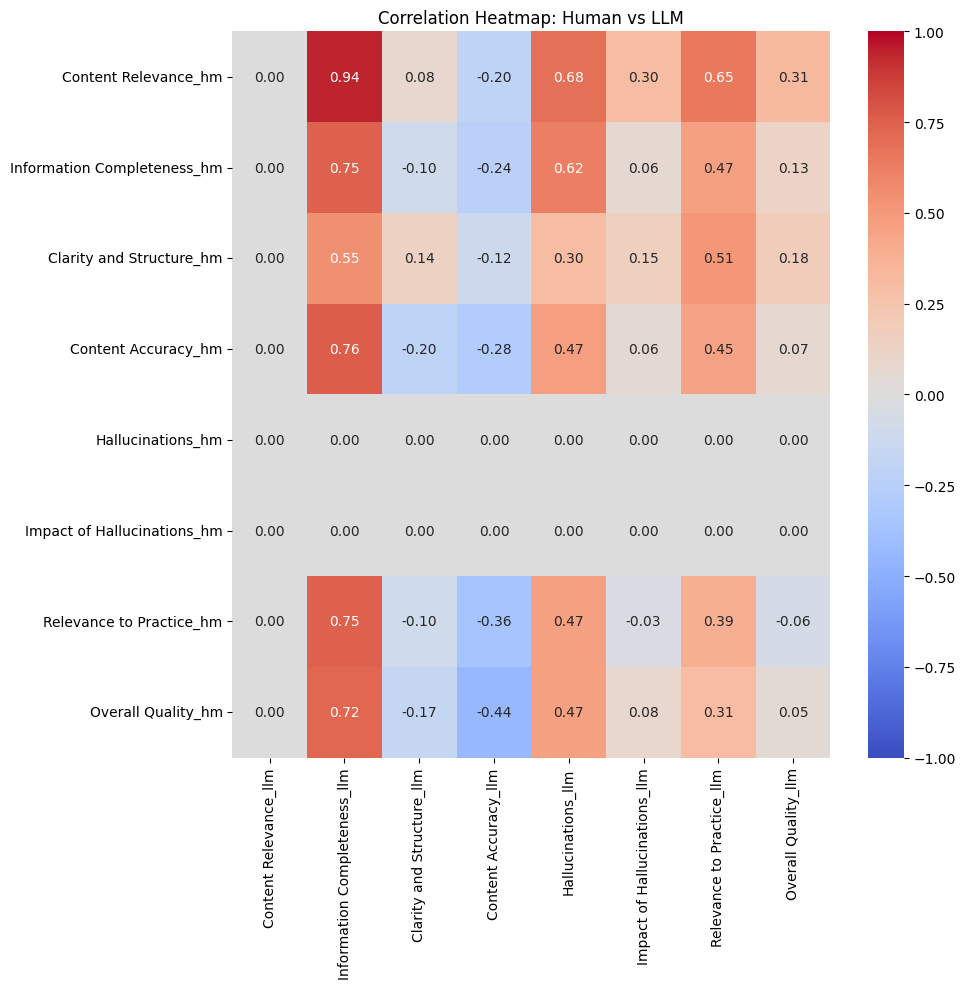

In [123]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def plot_correlation_heatmap(df_hm, df_llm, suffixes=("_hm", "_llm")):
    """Plot a heatmap of correlations."""
    
    df_hm_llm_corr = df_hm.merge(df_llm, on="filenameid", suffixes=suffixes)
    df_hm_llm_corr = df_hm_llm_corr.select_dtypes(include=[np.int64, np.float64]).corr().fillna(0)
    
    
    fig, ax = plt.subplots(figsize=(10, 10))
    x_suffix, y_suffix = suffixes[0], suffixes[1]
    x_cols = [col for col in df_hm_llm_corr.columns if col.endswith(x_suffix)]
    y_cols = [col for col in df_hm_llm_corr.columns if col.endswith(y_suffix)]

    corr_matrix = df_hm_llm_corr.loc[x_cols, y_cols]
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1, ax=ax)
    ax.set_title("Correlation Heatmap: Human vs LLM")
    fig.tight_layout()
    # plt.savefig(os.path.join(output_path, "correlation_heatmap.png"))   
    return fig , corr_matrix

fig, corr_matrix = plot_correlation_heatmap(df_human_, df_jud)

plt.savefig("output/evaluation/llama_3B_inst_std_prompt/correlation_heatmap.png")

In [124]:
def get_corr_scores(df_human, df_jud):
    """Compute the correlation scores."""
    
    corr_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        corr_scores[col] = np.corrcoef(df_human[col], df_jud[col])[0, 1]
    return corr_scores

corr_scores = get_corr_scores(df_human_, df_jud)
corr_scores

/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/home/bsc/bsc830651/.local/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


{'Content Relevance': nan,
 'Information Completeness': 0.7479575920067657,
 'Clarity and Structure': 0.13514747567989727,
 'Content Accuracy': -0.28235511231217136,
 'Hallucinations': nan,
 'Impact of Hallucinations': nan,
 'Relevance to Practice': 0.3901173649577245,
 'Overall Quality': 0.054554472558998035}

In [125]:
def get_mae_scores(df_human, df_jud):
    """Compute the mean absolute error scores."""
    
    mae_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        mae_scores[col] = np.mean(np.abs(df_human[col] - df_jud[col]))
    return mae_scores

mae_scores = get_mae_scores(df_human_, df_jud)
mae_scores

{'Content Relevance': 0.8666666666666667,
 'Information Completeness': 1.2,
 'Clarity and Structure': 0.6,
 'Content Accuracy': 1.0,
 'Hallucinations': 3.4,
 'Impact of Hallucinations': 3.533333333333333,
 'Relevance to Practice': 1.2,
 'Overall Quality': 0.9333333333333333}

In [126]:
from sklearn.metrics import f1_score
def get_f1_scores(df_human, df_jud):
    """Compute the F1 scores."""
    
    f1_scores = {}
    for col in df_human.select_dtypes(int).columns:
        if col == "filenameid":
            continue
        f1_scores[col] = f1_score(df_human[col], df_jud[col], average="weighted")
    return f1_scores

f1_scores = get_f1_scores(df_human_, df_jud)
f1_scores

{'Content Relevance': 0.3710144927536232,
 'Information Completeness': 0.25263157894736843,
 'Clarity and Structure': 0.4952380952380952,
 'Content Accuracy': 0.3218045112781954,
 'Hallucinations': 0.0,
 'Impact of Hallucinations': 0.0,
 'Relevance to Practice': 0.2571428571428572,
 'Overall Quality': 0.3255411255411255}

In [127]:
df_eval = pd.DataFrame([corr_scores, mae_scores, f1_scores]).T
df_eval.columns = ["correlation", "mae", "f1"]
df_eval

,correlation,mae,f1
Content Relevance,NaN,0.866667,0.371014
Information Completeness,0.747958,1.200000,0.252632
Clarity and Structure,0.135147,0.600000,0.495238
Content Accuracy,-0.282355,1.000000,0.321805
Hallucinations,NaN,3.400000,0.000000
Impact of Hallucinations,NaN,3.533333,0.000000
Relevance to Practice,0.390117,1.200000,0.257143
Overall Quality,0.054554,0.933333,0.325541


In [130]:
df_eval.to_csv("output/evaluation/llama_3B_inst_std_prompt/evaluation_scores.csv")

In [129]:
df_diff = (df_jud.select_dtypes(int) - df_human_.select_dtypes(int))
df_diff["filenameid"] = df_jud["filenameid"]

df_diff.select_dtypes(int).abs().mean()

Content Relevance           0.866667
Information Completeness    1.200000
Clarity and Structure       0.600000
Content Accuracy            1.000000
Hallucinations              3.400000
Impact of Hallucinations    3.533333
Relevance to Practice       1.200000
Overall Quality             0.933333
dtype: float64

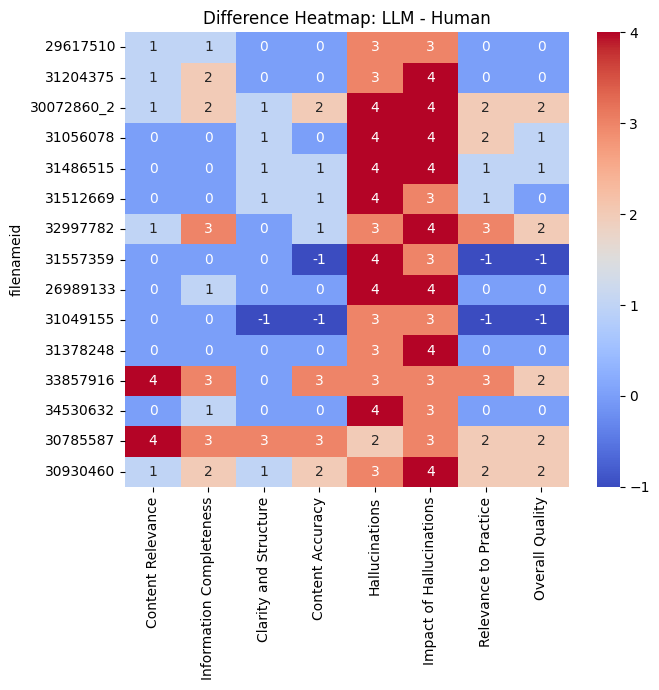

In [131]:
import seaborn as sns

plt.figure(figsize=(7, 7))
sns.heatmap(df_diff.set_index("filenameid"), annot=True, cmap="coolwarm")
plt.title("Difference Heatmap: LLM - Human")
plt.tight_layout()
plt.savefig("output/evaluation/prometheus-2-7B/difference_heatmap.png")

In [132]:
col = "Information Completeness"
y_true = df_human_[col]
y_pred = df_jud[col]

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00         3
           5       0.46      1.00      0.63         6

    accuracy                           0.40        15
   macro avg       0.09      0.20      0.13        15
weighted avg       0.18      0.40      0.25        15



In [133]:
df_jud

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,filenameid
0,5,5,4,5,4,4,5,4,29617510
1,5,5,4,4,4,5,4,4,31204375
2,5,5,5,5,5,5,5,5,30072860_2
3,5,5,4,5,5,5,5,5,31056078
4,5,5,5,5,5,5,5,5,31486515
5,5,5,5,5,5,4,5,4,31512669
6,5,5,5,5,4,5,5,5,32997782
7,5,5,4,4,5,4,4,4,31557359
8,5,5,5,5,5,5,5,5,26989133
9,5,5,4,4,4,4,4,4,31049155


In [48]:
df_human_

,Content Relevance,Information Completeness,Clarity and Structure,Content Accuracy,Hallucinations,Impact of Hallucinations,Relevance to Practice,Overall Quality,Positive highlights,Negative highlights,Other Comments,filenameid
0,4,4,4,5,1,1,5,4,,"falta información sobre tipo de prótesis, ause...",,29617510
1,4,3,4,4,1,1,4,4,,Se pierde mucha información sobre la explicaci...,,31204375
2,4,3,4,3,1,1,3,3,ordena muy bien los resultados de la ecografía.,Faltan los datos hemodinámicos cardiacos y pul...,,30072860_2
3,5,5,3,5,1,1,3,4,"datos muy completos, estrcutura fiel al docume...",La parte correspondiente a la enfermedad actu...,,31056078
4,5,5,4,4,1,1,4,4,,Se debería mencionar el motivo de admisión: an...,,31486515
5,5,5,4,4,1,1,4,4,Muy bien especificado Chief complaint,Se podría separar la enfermedad actual de los ...,,31512669
6,4,2,5,4,1,1,2,3,Very well structured and explained. Abbrevatio...,"The text has been oversummarized, leaving out ...",,32997782
7,5,5,4,5,1,1,5,5,,la razón de admisión suele ser algo más genera...,,31557359
8,5,4,5,5,1,1,5,5,,,,26989133
9,5,5,5,5,1,1,5,5,,,,31049155


In [135]:
col = "Overall Quality"
y_true = df_human_[col]
y_pred = df_jud[col]

from sklearn.metrics import classification_report

print(classification_report(y_true, y_pred, zero_division=0))

              precision    recall  f1-score   support

           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         3
           4       0.50      0.67      0.57         6
           5       0.29      0.50      0.36         4

    accuracy                           0.40        15
   macro avg       0.20      0.29      0.23        15
weighted avg       0.28      0.40      0.33        15



In [57]:
df_qual_eval = df_prompt.copy()
df_qual_eval.set_index("filenameid", inplace=True)
df_fb = df_qual_eval["feedbacks"].apply(pd.Series)
print(df_fb.loc["33857916"].to_markdown())

|                          | 33857916                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

In [60]:
print(df_human_[df_human_["filenameid"] == "33857916"].T.to_markdown())

|                          | 11                                                                                                                                                        |
|:-------------------------|:----------------------------------------------------------------------------------------------------------------------------------------------------------|
| Content Relevance        | 1                                                                                                                                                         |
| Information Completeness | 1                                                                                                                                                         |
| Clarity and Structure    | 4                                                                                                                                                         |
| Content Accuracy         | 2                                             